In [1]:
import numpy as np
import torch.nn as nn
from torch.nn import parameter
import torch.nn.functional as F
import torch.optim as optimizer
from torch.nn.init import xavier_uniform_
import torch
import gym

def xavier(param):
    xavier_uniform_(param)

def weights_init(m):
    if isinstance(m, nn.Linear):
        xavier(m.weight.data)
        m.bias.data.zero_()

!pip install livelossplot --quiet
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np

In [31]:
class ParameterisedPolicyNetwork(nn.Module):

    def __init__(self, state_space_cardinality, action_space_cardinality):
        super().__init__()
        self.input_fc = nn.Linear(in_features=state_space_cardinality, out_features=64)
        self.relu = nn.ReLU()
        self.output_fc = nn.Linear(
            in_features=64, out_features=action_space_cardinality)

        self.input_fc.apply(weights_init)
        self.output_fc.apply(weights_init)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.relu(x)
        x = F.softmax(self.output_fc(x))  

        return x

class ParameterisedValueFunctionNetwork(nn.Module):

    def __init__(self, state_space_cardinality) -> None:
        super().__init__()
        self.input_fc = nn.Linear(in_features=state_space_cardinality, out_features=64)
        self.relu = nn.ReLU()
        self.output_fc = nn.Linear(in_features=64, out_features=1)

        self.input_fc.apply(weights_init)
        self.output_fc.apply(weights_init)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.relu(x)
        x = self.output_fc(x)

        return x

In [3]:
def determine_action(S_t, parameterised_policy, action_space_cardinality):
    parameterised_policy.eval()
    pi_given_S = parameterised_policy(torch.FloatTensor(S_t)).cpu().detach().numpy()
    
    A_t = np.random.choice(action_space_cardinality, p=pi_given_S)
    return A_t

In [43]:
def update_w(delta, optimizer_w, parameterised_value_func, S_t):
    parameterised_value_func.train()
    optimizer_w.zero_grad()
    loss_value = torch.sum( (torch.FloatTensor(delta) * parameterised_value_func(torch.FloatTensor(S_t)))) # delta is just a constant that can be multiplied
    loss_value.backward()
    optimizer_w.step()
    return loss_value.data.item()

def update_theta(delta, optimizer_theta, parameterised_policy, A_t, S_t, gamma, t=None,  I=None):
    parameterised_policy.train()
    optimizer_theta.zero_grad()
    pi_given_S = parameterised_policy(torch.FloatTensor(S_t))
    loss_policy = -torch.sum( (I* torch.FloatTensor(delta)* torch.log(pi_given_S[A_t])))
    loss_policy.backward()
    optimizer_theta.step()
    # print('w loss:', loss_policy.data.item())
    return loss_policy.data.item()

In [44]:
def one_step_actor_critic(alpha_w, alpha_theta, gamma, env, episodes):
    state_space_cardinality = env.observation_space.shape[0]
    action_space_cardinality = env.action_space.n
    parameterised_policy = ParameterisedPolicyNetwork(state_space_cardinality=state_space_cardinality, action_space_cardinality=action_space_cardinality)
    parameterised_value_func = ParameterisedValueFunctionNetwork(state_space_cardinality=state_space_cardinality)

    optimizer_theta = optimizer.Adam( parameterised_policy.parameters(), lr=alpha_theta)
    optimizer_w = optimizer.Adam( parameterised_value_func.parameters(), lr=alpha_w)
    scheduler_theta = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_theta, T_max=episodes)
    scheduler_w = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_w, T_max=episodes)

    accumulated_rewards = []
    liveloss = PlotLosses()
    
    for episode in range(episodes):
        S_t = env.reset()
        I = 1
        accumulated_reward = 0
        logs = {}
        loss_w = 0.0
        loss_theta = 0.0
        
        while True:
            A_t = determine_action(S_t, parameterised_policy, action_space_cardinality)
            S_t_next, R_t, terminal, _ = env.step(A_t)
            accumulated_reward += R_t

            parameterised_value_func.eval()
            if not terminal:
                delta = R_t + gamma*parameterised_value_func(torch.FloatTensor(S_t_next)).detach().numpy() - parameterised_value_func(torch.FloatTensor(S_t)).detach().numpy() 
            else:
                delta = R_t - parameterised_value_func(torch.FloatTensor(S_t)).detach().numpy()
            loss_w     += update_w(delta, optimizer_w, parameterised_value_func, S_t)
            loss_theta += update_theta(delta, optimizer_theta, parameterised_policy, A_t, S_t, gamma, I=I)

            scheduler_theta.step()
            scheduler_w.step()
            if terminal:
                break
            I *= gamma
            S_t = S_t_next
            
        
        if len(accumulated_rewards) >= 100:
            accumulated_rewards[episode%len(accumulated_rewards)] = accumulated_reward
        else:
            accumulated_rewards.append(accumulated_reward)
        
        logs['vFunc training loss'] = loss_w
        logs['policy training loss'] = loss_theta
        logs['sum of rewards'] = np.mean(accumulated_rewards)
        liveloss.update(logs)
        liveloss.send()
        print("EPISODE: {}, SUM OF REWARDS: {}, ACC SUM REWS {}".format(
            episode, accumulated_reward, np.mean(accumulated_rewards)))

In [ ]:
def main():
    print(2e-14)
    ALPHA_THETA = 2**-12
    ALPHA_W = 2**-12

    GAMMA = 0.99
    EPISODES = 5000
    print(ALPHA_W, ALPHA_THETA)

    env = gym.make('CartPole-v0')
    one_step_actor_critic(
        alpha_w=ALPHA_W, alpha_theta=ALPHA_THETA, gamma=GAMMA,env = env, episodes=EPISODES)


if __name__ == "__main__":
    main()

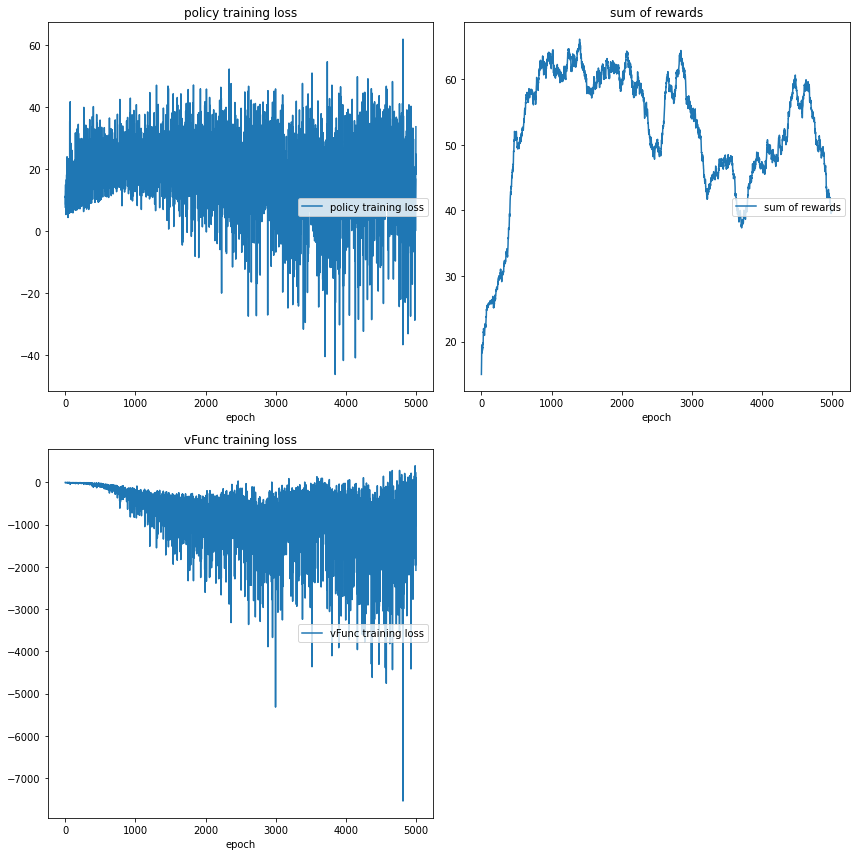

policy training loss
	policy training loss 	 (min:  -46.287, max:   61.917, cur:   33.659)
sum of rewards
	sum of rewards   	 (min:   15.000, max:   66.110, cur:   39.950)
vFunc training loss
	vFunc training loss 	 (min: -7543.677, max:  392.911, cur: -2081.677)
EPISODE: 4999, SUM OF REWARDS: 73.0, ACC SUM REWS 39.95


In [47]:
def main():
    print(2e-14)
    ALPHA_THETA = 2**-13
    ALPHA_W = 2**-16

    GAMMA = 0.99
    EPISODES = 5000
    env = gym.make('CartPole-v0')
    one_step_actor_critic(
        alpha_w=ALPHA_W, alpha_theta=ALPHA_THETA, gamma=GAMMA,env = env, episodes=EPISODES)


if __name__ == "__main__":
    main()

In [ ]:
def main():
    print(2e-14)
    ALPHA_THETA = 2**-12
    ALPHA_W = 2**-12
    GAMMA = 0.99
    EPISODES = 1000
    env = gym.make('Acrobot-v1')
    one_step_actor_critic(
        alpha_w=ALPHA_W, alpha_theta=ALPHA_THETA, gamma=GAMMA,env = env, episodes=EPISODES)


if __name__ == "__main__":
    main()

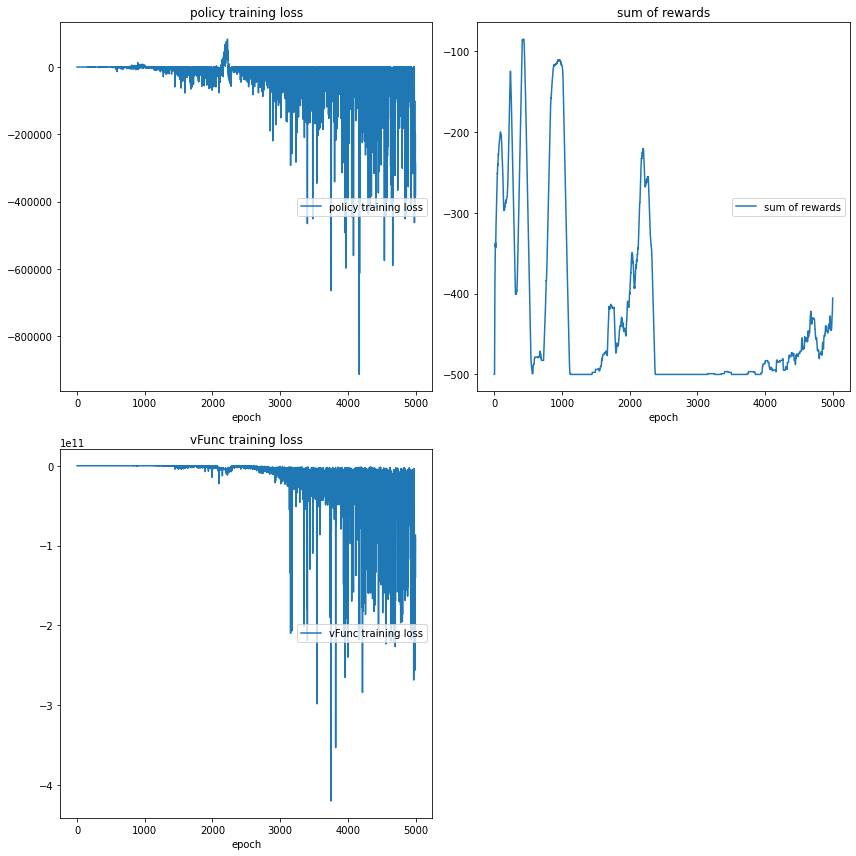

policy training loss
	policy training loss 	 (min: -914203.472, max: 82836.278, cur: -287645.794)
sum of rewards
	sum of rewards   	 (min: -500.000, max:  -85.280, cur: -405.500)
vFunc training loss
	vFunc training loss 	 (min: -420006819703.500, max: -665.890, cur: -86778544548.000)
EPISODE: 4999, SUM OF REWARDS: -110.0, ACC SUM REWS -405.5


In [36]:
def main():
    print(2e-14)
    ALPHA_THETA = 2**-16
    ALPHA_W = 2**-13

    # ALPHA_theta, ALPHA_w for REINFORCE w b: 12,9 works; 10,7 works; 9,7 works kind off but very unstable; 10,8 works 
    GAMMA = 0.99
    EPISODES = 1000
    print(ALPHA_W, ALPHA_THETA)

    env = gym.make('Acrobot-v1')

    # reinforce_with_baseline(
    #     alpha_w=ALPHA_W, alpha_theta=ALPHA_THETA, gamma=GAMMA,env = env, episodes=EPISODES)
    one_step_actor_critic(
        alpha_w=ALPHA_W, alpha_theta=ALPHA_THETA, gamma=GAMMA,env = env, episodes=EPISODES)


if __name__ == "__main__":
    main()